Goal: train - test - validation

# Prepare Datasets

In [5]:
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # RGB (0.5,0.5,0.5)
])



In [6]:
trainset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data', download = True, train = True, transform = transform)

print(len(trainset))

60000


In [7]:
N_train = 55000
N_valid = 5000

trainset, validset = torch.utils.data.random_split(trainset, [N_train, N_valid])

testset = datasets.FashionMNIST(root='~/.pytorch/F_MNIST_data', download = True, train = False, transform = transform)

In [9]:
print(len(trainset))
print(len(validset))
print(len(testset))

55000
5000
10000


In [10]:
bs = 64

trainloader = torch.utils.data.DataLoader(trainset, batch_size = bs, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size = bs, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size = bs, shuffle=False)

In [11]:
print(len(trainloader)) # num. of batches

860


In [12]:
print(len(trainloader.dataset)) # num. of samples

55000


# Build Model

In [14]:
from torch import nn, optim
import torch.nn.functional as F

In [15]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # logits ===> CrossEntropyLoss
        
        x = F.log_softmax(x, dim=1)
        
        return x

In [16]:
model = Classifier()

In [17]:
if torch.cuda.is_available():
    my_device = torch.device('cuda')
else:
    my_device = torch.device('cpu')
print(my_device)

cuda


In [18]:
model.to(my_device)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [19]:
criterion = nn.NLLLoss()

In [20]:
optimizer = optim.Adam(model.parameters(), lr = 0.003) # for each param, it holds one learning rate. 

# Train netwrok

In [21]:
def train_loop(trainloader, model, criterion, optimizer):
    
    running_loss = 0
    
    for images, labels in trainloader:
        
        images = images.to(my_device)
        labels = labels.to(my_device)
        
        optimizer.zero_grad()
        
        log_ps = model(images) # ps = torch.exp(log_ps)
        
        loss = criterion(log_ps, labels)
        
        running_loss += loss.item()*images.shape[0]
        
        loss.backward()
        
        optimizer.step()
    
    train_loss = running_loss / len(trainloader.dataset)
    
    return train_loss

In [22]:
def test_loop(testloader, model, criterion):
    running_loss = 0
    
    test_correct = 0 # number of correct predictions
    
    with torch.no_grad():
        for images, labels in testloader:
            
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            log_ps = model(images) # ps = torch.exp(log_ps)
            
            loss = criterion(log_ps, labels)
            
            running_loss += loss.item()*images.shape[0]
            
            # compute accuracy
            ps = torch.exp(log_ps) # probabilities for each class
            top_p, top_class = ps.topk(1, dim=1)
            
            equals = top_class == labels.view(*top_class.shape) # labels ==> [64,]  64*1
            
            test_correct += equals.sum().item()
    
    test_loss = running_loss / len(testloader.dataset)
    test_acc = test_correct / len(testloader.dataset)
    
    return test_loss, test_acc

In [23]:
epochs = 10 # epochs = 60 

train_losses, valid_losses = [], []

for e in range(epochs):
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    
    # validation
    valid_loss, valid_acc = test_loop(validloader, model, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print("Epoch: {}/{} ..".format(e + 1, epochs), 
          "Training loss: {:.3f} .. ".format(train_loss),
          "Valid loss: {:.3f} .. ".format(valid_loss),
          "Valid Accuracy: {:.3f} .. ".format(valid_acc),
         )

Epoch: 1/10 .. Training loss: 0.525 ..  Valid loss: 0.445 ..  Valid Accuracy: 0.832 .. 
Epoch: 2/10 .. Training loss: 0.393 ..  Valid loss: 0.411 ..  Valid Accuracy: 0.851 .. 
Epoch: 3/10 .. Training loss: 0.357 ..  Valid loss: 0.389 ..  Valid Accuracy: 0.866 .. 
Epoch: 4/10 .. Training loss: 0.336 ..  Valid loss: 0.364 ..  Valid Accuracy: 0.876 .. 
Epoch: 5/10 .. Training loss: 0.320 ..  Valid loss: 0.348 ..  Valid Accuracy: 0.874 .. 
Epoch: 6/10 .. Training loss: 0.307 ..  Valid loss: 0.350 ..  Valid Accuracy: 0.875 .. 
Epoch: 7/10 .. Training loss: 0.295 ..  Valid loss: 0.341 ..  Valid Accuracy: 0.883 .. 
Epoch: 8/10 .. Training loss: 0.285 ..  Valid loss: 0.343 ..  Valid Accuracy: 0.883 .. 
Epoch: 9/10 .. Training loss: 0.276 ..  Valid loss: 0.375 ..  Valid Accuracy: 0.872 .. 
Epoch: 10/10 .. Training loss: 0.268 ..  Valid loss: 0.355 ..  Valid Accuracy: 0.883 .. 


**Expected accuracy on validation set after around 60 epochs = 0.885**

In [24]:
import matplotlib.pyplot as plt

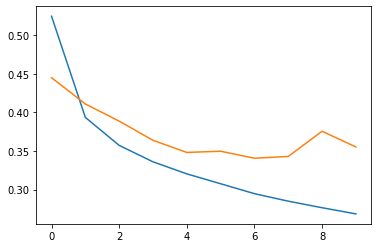

In [25]:
plt.plot(train_losses, label = "Training loss")
plt.plot(valid_losses, label = "Validation loss")


# Reduce overfitting through Early Stopping and Dropout

Example:

Effect of dropout's hyper-parameter on the performance.

https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

In [26]:
class ClassifierWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        self.dropout = nn.Dropout(p = 0.2) # hyper-parameter
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = self.fc4(x) 
        
        x = F.log_softmax(x, dim=1)
        
        return x

In [27]:
model2 = ClassifierWithDropout()

In [28]:
model2.to(my_device)

ClassifierWithDropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## train the second model

In [29]:
def test_loop_2(testloader, model, criterion):
    running_loss = 0
    
    test_correct = 0 # number of correct predictions
    
    # dropout layer is deactivated.
    model.eval()
    
    with torch.no_grad():
        for images, labels in testloader:
            
            images = images.to(my_device)
            labels = labels.to(my_device)
            
            log_ps = model(images) # ps = torch.exp(log_ps)
            
            loss = criterion(log_ps, labels)
            
            running_loss += loss.item()*images.shape[0]
            
            # compute accuracy
            ps = torch.exp(log_ps) # probabilities for each class
            top_p, top_class = ps.topk(1, dim=1)
            
            equals = top_class == labels.view(*top_class.shape) # labels ==> [64,]  64*1
            
            test_correct += equals.sum().item()
    
    # activate dropout layer
    model.train()
    
    test_loss = running_loss / len(testloader.dataset)
    test_acc = test_correct / len(testloader.dataset)
    
    return test_loss, test_acc

In [31]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model2.parameters(), lr = 0.003) 

In [32]:
epochs = 10 # epochs = 60 

train_losses, valid_losses = [], []

for e in range(epochs):
    train_loss = train_loop(trainloader, model2, criterion, optimizer)
    
    # validation
    valid_loss, valid_acc = test_loop_2(validloader, model2, criterion)
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print("Epoch: {}/{} ..".format(e + 1, epochs), 
          "Training loss: {:.3f} .. ".format(train_loss),
          "Valid loss: {:.3f} .. ".format(valid_loss),
          "Valid Accuracy: {:.3f} .. ".format(valid_acc),
         )

Epoch: 1/10 .. Training loss: 0.616 ..  Valid loss: 0.458 ..  Valid Accuracy: 0.835 .. 
Epoch: 2/10 .. Training loss: 0.483 ..  Valid loss: 0.425 ..  Valid Accuracy: 0.843 .. 
Epoch: 3/10 .. Training loss: 0.452 ..  Valid loss: 0.419 ..  Valid Accuracy: 0.846 .. 
Epoch: 4/10 .. Training loss: 0.432 ..  Valid loss: 0.391 ..  Valid Accuracy: 0.869 .. 
Epoch: 5/10 .. Training loss: 0.419 ..  Valid loss: 0.377 ..  Valid Accuracy: 0.863 .. 
Epoch: 6/10 .. Training loss: 0.404 ..  Valid loss: 0.369 ..  Valid Accuracy: 0.866 .. 
Epoch: 7/10 .. Training loss: 0.405 ..  Valid loss: 0.383 ..  Valid Accuracy: 0.860 .. 
Epoch: 8/10 .. Training loss: 0.399 ..  Valid loss: 0.399 ..  Valid Accuracy: 0.851 .. 
Epoch: 9/10 .. Training loss: 0.394 ..  Valid loss: 0.354 ..  Valid Accuracy: 0.876 .. 
Epoch: 10/10 .. Training loss: 0.383 ..  Valid loss: 0.367 ..  Valid Accuracy: 0.872 .. 


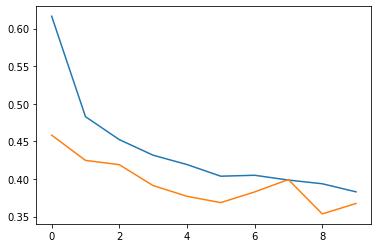

In [33]:
plt.plot(train_losses, label = "Training loss")
plt.plot(valid_losses, label = "Validation loss")

# Inference / Prediction on test set

In [34]:
test_loss, test_acc = test_loop_2(testloader, model2, criterion)

print("Our model's performance on test set")
print("Test loss: {:.3} .. ".format(test_loss), "Test accuracy: {:.3f}".format(test_acc))

Our model's performance on test set
Test loss: 0.386 ..  Test accuracy: 0.869


In [35]:
test_loss, test_acc = test_loop_2(testloader, model, criterion)

print("Our first model's performance on test set")
print("Test loss: {:.3} .. ".format(test_loss), "Test accuracy: {:.3f}".format(test_acc))

Our first model's performance on test set
Test loss: 0.459 ..  Test accuracy: 0.855
